## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ast import literal_eval

## Load data from OA and Grobid detection

In [2]:
#datasets_columns = ["ACDC","BRATS","LIDC-IDRI","DRIVE","PROMISE12","Chexpert","PadChest","PAD-UFES-20","CAMELYON","CADDementia","MRNet","PROSTATEx","MIMIC","CBIS-DDSM"]
datasets_columns = ["ACDC","BRATS","LIDC-IDRI","DRIVE","PROMISE12","Chexpert","MIMIC"]

datasets_columns.sort()
selected_venues = ["MICCAI","MIDL"]

In [27]:
papers_info = pd.read_csv("../../Results/extraction/papers_infos_openalex.csv")
df_detection = pd.read_csv("../../Results/extraction/grobid_fulltext_detection2.csv")
df_oa_references = pd.read_csv("../../Results/extraction/oa_reference_paper_dataset_location_format.csv")
df_oa_abstract = pd.read_csv("../../Results/extraction/oa_papers_datasets_abstract.csv")


In [50]:
import glob
i = 0
downloaded = [p.removeprefix("../../Results/extraction/fulltext/").removesuffix(".pdf") for p in glob.glob("../../Results/extraction/fulltext/*.pdf")]
for p in papers_info[papers_info["venue"]=="MIDL"]["title"].unique():
    if p not in downloaded:
        print(p)
print(i)

JOINED : Prior Guided Multi-task Learning for Joint Optic Disc/Cup Segmentation and Fovea Detection
Residual learning for 3D motion corrected quantitative MRI: Robust clinical T1 T2 and proton density mapping
Learning the Latent Heat Diffusion Process through Structural Brain Network from Longitudinal β-Amyloid Data
Joint Learning of Vessel Segmentation and Artery/Vein Classification with Post-processing
0


## Transform and merge detections from Grobid and OpenAlex

In [29]:
#Merge oa abstract and grobid detection
for row in df_oa_abstract.iterrows():
    row_value = row[1]
    for ds in datasets_columns:
        if row_value[ds]:
            if row_value["name"] in df_detection["doc_name"].unique():
                df_detection[(df_detection["doc_name"]==row_value["name"])&(df_detection["label1"]==ds)&(df_detection["label2"]=="In abstract")]["value"]=True
            else:
                new_row = {"doc_name":[row_value["name"]],"label1":[ds],"label2":["In Abstract"],"value":[True]}
                df_detection = pd.concat([df_detection,pd.DataFrame(new_row)],ignore_index=True)

In [30]:
def get_venue(doc_name):
    if doc_name in papers_info["title"].unique():
        return papers_info[papers_info["title"]==doc_name]["venue"].to_list()[0]
    return "None"
df_detection["venue"] = df_detection["doc_name"].apply(get_venue)
df_oa_references["venue"] = df_oa_references["doc_name"].apply(get_venue)


def get_year(doc_name):
    if doc_name in papers_info["title"].unique():
        return papers_info[papers_info["title"]==doc_name]["year"].to_list()[0]
    return 0
df_detection["year"] = df_detection["doc_name"].apply(get_year)
df_oa_references["year"] = df_oa_references["doc_name"].apply(get_year)

df_oa_references = df_oa_references[df_oa_references["venue"].isin(selected_venues)]

KeyboardInterrupt: 

## Visualisation

In [ ]:
def match_citation_mention(doc_name,label,df_detection):
    if doc_name in df_detection["doc_name"].unique():
        if df_detection[(df_detection["doc_name"] == doc_name) & (df_detection["label1"] == label) & (df_detection["label2"] != "Elsewhere")]["value"].any():
            return True
    return False
    
total_citation = len(df_oa_references[df_oa_references["value"]])
cited_and_mentioned = df_oa_references[df_oa_references["value"]].apply(lambda x:match_citation_mention(x["doc_name"],x["label1"],df_detection),axis=1)
only_cited = ~cited_and_mentioned

In [ ]:
def match_mention_citation(doc_name,label,df_references):
    if doc_name in df_references["doc_name"].unique():
        if df_references[(df_references["doc_name"] == doc_name) & (df_references["label1"] == label)]["value"].any():
            return True
    return False

df_detection_merge_dataset = df_detection[(df_detection["value"]) & (df_detection["label2"] != "Elsewhere")].drop_duplicates(subset=["doc_name","label1"])
total_detection = len(df_detection_merge_dataset)
mentioned_and_cited = df_detection_merge_dataset.apply(lambda x:match_mention_citation(x["doc_name"],x["label1"],df_oa_references),axis=1)
only_mentioned = ~mentioned_and_cited

In [ ]:
count_mention_cited_dataset_venue = df_detection_merge_dataset[mentioned_and_cited].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
count_mention_dataset_venue = df_detection_merge_dataset[only_mentioned].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
count_cited_dataset_venue = df_oa_references[df_oa_references["value"]][only_cited].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
total_presence_dataset_venue = count_cited_dataset_venue.add(count_mention_cited_dataset_venue,fill_value=0).add(count_mention_dataset_venue,fill_value=0)[selected_venues]

In [ ]:
perc_citation_venue = ((count_cited_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T
perc_mention_venue = ((count_mention_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T
perc_both_venue = ((count_mention_cited_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T

### Presence’s type stackbar plot per venue and dataset

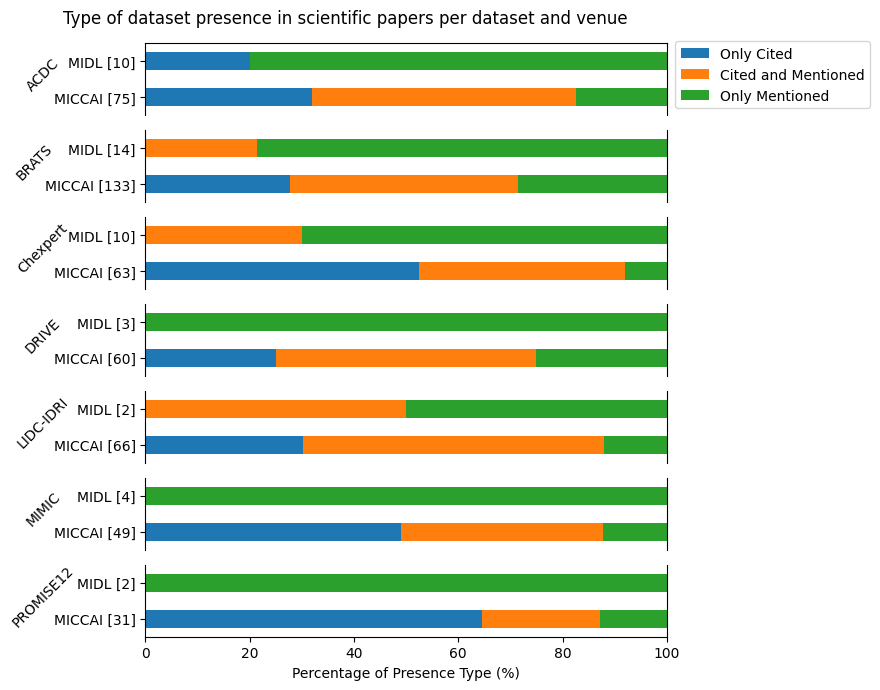

In [ ]:
f,axes = plt.subplots(len(datasets_columns),1,figsize=(7,7))
for i,dataset in enumerate(datasets_columns):
    ax = axes[i]
    mention_per = perc_mention_venue[dataset]
    cite_per = perc_citation_venue[dataset]
    both_per = perc_both_venue[dataset]
    df = pd.DataFrame(data=[cite_per,both_per,mention_per])
    df.index = ["Only Cited","Cited and Mentioned", "Only Mentioned"]
    ax = df.T.plot.barh(stacked=True,ax=ax)
    ax.get_legend().remove()
    ax.set_ylabel(dataset,rotation=45)
    ax.set_yticklabels([f"{venue} [{int(total_presence_dataset_venue.loc[dataset][venue])}]" for venue in total_presence_dataset_venue.loc[dataset].index])
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(0,100)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

axes[0].spines["top"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.get_xaxis().set_visible(True)
ax.set_xlabel("Percentage of Presence Type (%)")
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels,bbox_to_anchor=(1.26, 0.944))
plt.suptitle("Type of dataset presence in scientific papers per dataset and venue")
f.tight_layout()


In [ ]:
total_presence_dataset_venue

venue,MICCAI,MIDL
label1,,
ACDC,75.0,10.0
BRATS,133.0,14.0
CADDementia,1.0,0.0
CAMELYON,22.0,7.0
CBIS-DDSM,12.0,0.0
ChestX-Ray14,11.0,1.0
Chexpert,63.0,10.0
DRIVE,60.0,3.0
LIDC-IDRI,66.0,2.0


## Cumulative count of mentions per year and dataset

<Figure size 640x480 with 0 Axes>

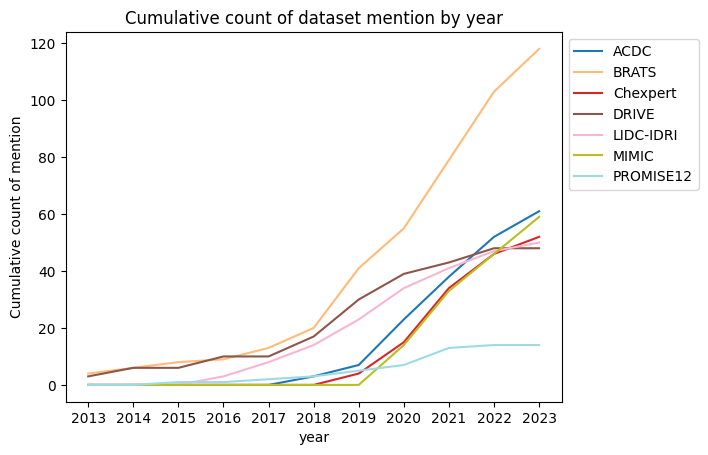

In [ ]:
cumulcount_per_dataset_and_year = df_detection[df_detection["value"] &(df_detection["label1"].isin(datasets_columns)) & (df_detection["year"]!=0)].drop_duplicates(subset=["doc_name","label1","value"]).groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T
plt.figure()
cmap = colormaps.get_cmap('tab20')
cumulcount_per_dataset_and_year.plot(cmap=cmap)
plt.ylabel("Cumulative count of mention")
plt.xticks([int(year) for year in cumulcount_per_dataset_and_year.index])
plt.title("Cumulative count of dataset mention by year")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Cumulative count of mention per year and dataset

<Figure size 640x480 with 0 Axes>

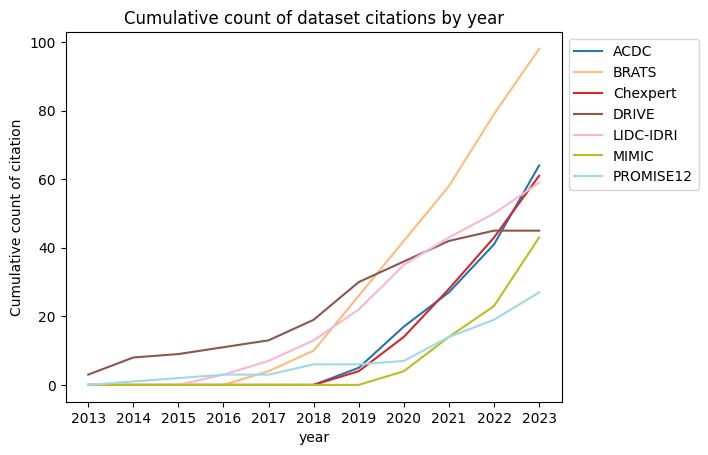

In [ ]:
cumulcount_per_dataset_and_year = df_oa_references[df_oa_references["value"]].groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T

plt.figure()
cmap = colormaps.get_cmap('tab20')
cumulcount_per_dataset_and_year[datasets_columns].plot(cmap=cmap)
plt.ylabel("Cumulative count of citation")
plt.xticks([int(year) for year in cumulcount_per_dataset_and_year.index])
plt.title("Cumulative count of dataset citations by year")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
cumulcount_per_dataset_and_year.T

year,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
label1,,,,,,,,,,,
ACDC,0.0,0.0,0.0,0.0,0.0,0.0,5.0,17.0,27.0,41.0,64.0
BRATS,0.0,0.0,0.0,0.0,4.0,10.0,26.0,42.0,58.0,79.0,98.0
CADDementia,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
CAMELYON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,6.0,11.0
CBIS-DDSM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,6.0
Chexpert,0.0,0.0,0.0,0.0,0.0,0.0,4.0,14.0,28.0,43.0,61.0
DRIVE,3.0,8.0,9.0,11.0,13.0,19.0,30.0,36.0,42.0,45.0,45.0
LIDC-IDRI,0.0,0.0,0.0,3.0,7.0,13.0,22.0,35.0,43.0,50.0,59.0
MIMIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,14.0,23.0,43.0


### Location of presence in full text

<Figure size 640x480 with 0 Axes>

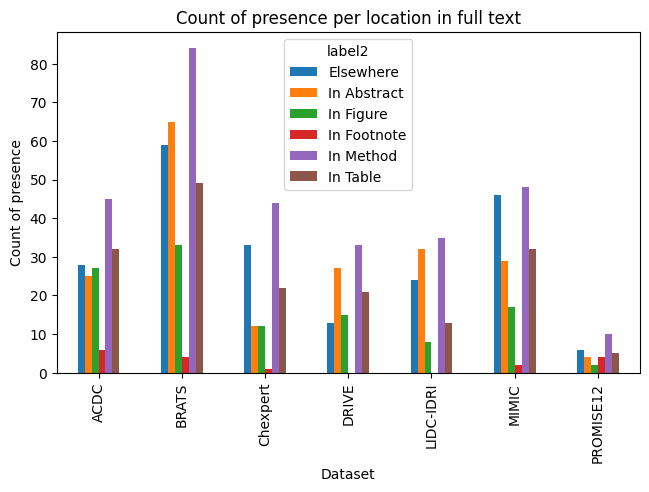

label2,Elsewhere,In Abstract,In Figure,In Footnote,In Method,In Table
label1,,,,,,
ACDC,28.0,25.0,27.0,6.0,45.0,32.0
BRATS,59.0,65.0,33.0,4.0,84.0,49.0
Chexpert,33.0,12.0,12.0,1.0,44.0,22.0
DRIVE,13.0,27.0,15.0,0.0,33.0,21.0
LIDC-IDRI,24.0,32.0,8.0,0.0,35.0,13.0
MIMIC,46.0,29.0,17.0,2.0,48.0,32.0
PROMISE12,6.0,4.0,2.0,4.0,10.0,5.0


In [ ]:
df_dataset = df_detection[['label1','label2','value']].groupby(['label1','label2']).sum().unstack().fillna(0).droplevel(0,axis=1)
plt.figure()
df_dataset[df_dataset.index.isin(datasets_columns)].plot.bar()
plt.tight_layout()
plt.title("Count of presence per location in full text")
plt.xlabel('Dataset')
plt.ylabel('Count of presence')
plt.show()
df_dataset[df_dataset.index.isin(datasets_columns)]

## Mean number of references (not only dataset) per year in MICCAI

Text(0, 0.5, 'Mean number of references')

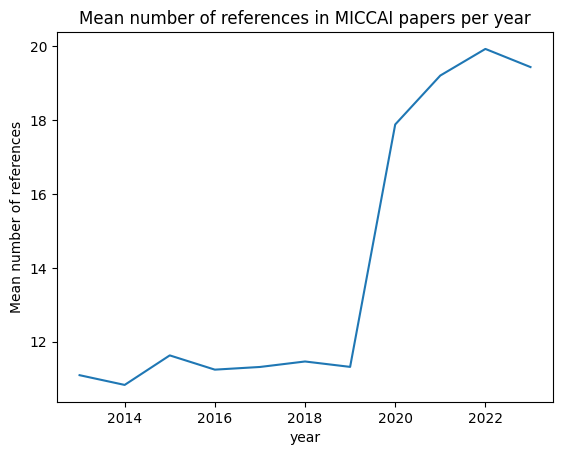

In [ ]:
def number_of_reference(x):
    if x == x:
        list_ref = literal_eval(x)
        return len(list_ref)
    else:
        return 0
papers_info["nb_ref"] = papers_info["references"].apply(number_of_reference)
#df_oa.groupby(["venue","year"]).sum()["nb_ref"].unstack().fillna(0)["MICCAI"] / df_oa.groupby(["venue","year"]).sum()
plt.figure()
plt.title("Mean number of references in MICCAI papers per year")
(papers_info.groupby(["venue","year"]).sum()["nb_ref"].unstack().fillna(0).T["MICCAI"] / papers_info.groupby(["venue","year"]).size().unstack().fillna(0).T["MICCAI"]).plot()
plt.ylabel("Mean number of references")

## Number of citations per venue

<Axes: xlabel='venue'>

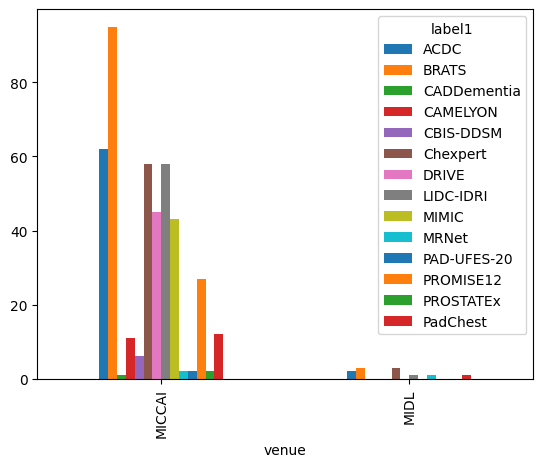

In [ ]:
df_oa_references[df_oa_references["value"]].groupby(["venue","label1"]).count()["doc_name"].unstack().fillna(0).plot.bar()

## Test place

In [ ]:
df_detection[df_detection["label1"]=="DRIVE"]

,doc_name,label1,label2,value,venue,year
102,Boosting Connectivity in Retinal Vessel Segmen...,DRIVE,In Method,True,MICCAI,2020.0
103,Boosting Connectivity in Retinal Vessel Segmen...,DRIVE,In Figure,True,MICCAI,2020.0
104,Boosting Connectivity in Retinal Vessel Segmen...,DRIVE,In Table,True,MICCAI,2020.0
110,Learning to Address Intra-segment Misclassific...,DRIVE,In Abstract,True,MICCAI,2021.0
111,Learning to Address Intra-segment Misclassific...,DRIVE,In Method,True,MICCAI,2021.0
...,...,...,...,...,...,...
1197,Multiscale Network Followed Network Model for ...,DRIVE,In Abstract,True,MICCAI,2018.0
1198,Deep Random Walk for Drusen Segmentation from ...,DRIVE,In Abstract,True,MICCAI,2018.0
1199,Retinal Artery and Vein Classification via Dom...,DRIVE,In Abstract,True,MICCAI,2018.0
1203,DeepVessel: Retinal Vessel Segmentation via De...,DRIVE,In Abstract,True,MICCAI,2016.0
